In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-learn Pipelines 1

Goals:
- Principal Component Analysis (PCA) as dimensionality reduction technique.
- Scikit-learn pipelines

Notes:
- Fine-tuning the pipeline(s) is beyond the scope of this lecture.
- More complicated Scikit-learn pipelines will be explored in the next lectures.

## 1. Import and explore the dataset

The iris dataset is a very well-known dataset used in many lectures/examples.\
It consists of 3 different types of irises’ (Setosa, Versicolor, and Virginica) petal and sepal length, stored in a 150x4 numpy array.\
The rows are the 150 iris samples, the columns are the values measured for the sepal length, sepal width, petal length and petal width.

### 1.1 Quick exploration

In [2]:
iris = sns.load_dataset('iris')

Seaborn imports the dataset as a single pandas dataframe (iris) containing both the characteristics of the flower and their classification.

Alternative: input via scikit-learn

    from sklearn import datasets
    iris, target = datasets.load_iris(return_X_y=True, as_frame=True)

Scikit-learn imports the dataset as a pandas dataframe (iris) and a pandas series (target).\
'iris' contains the characteristics of the flower, and 'target' their classification (0, 1, or 2)

In [3]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

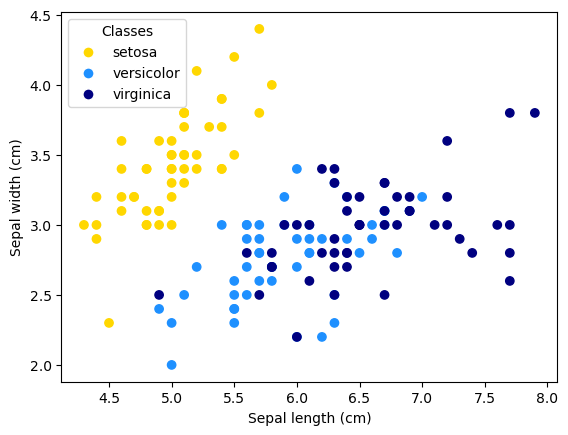

In [5]:
def plot_original_data(iris):

    from matplotlib.lines import Line2D
    colors = {'setosa':'gold', 'versicolor':'dodgerblue', 'virginica':'navy'}

    fig, ax = plt.subplots()
    scat = ax.scatter(iris.sepal_length, iris.sepal_width, c=iris.species.map(colors))
    ax.set(xlabel='Sepal length (cm)', ylabel='Sepal width (cm)')
    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
    legend = ax.legend(handles = handles, loc='upper left', title='Classes') 

plot_original_data(iris)

The plot showsthat it is easy to classify the first class ('Setosa') based on 'Sepal length' and 'Sepal width'. However, in these coordinates, 'versicolor' and 'virginica' overlap and cannot be separated.

### 1.2 PCA decomposition: generalities

PCA (**Principal Components Analysis**) transforms correlated features in the dataset into a set of linearly
independent (=orthogonal) features.

In [ ]:
# TBD INCLUDE FIGURE HERE

In [ ]:
# TBD INCLUDE MATH HERE?

Notes:
- PCA only works with numerical features.
- PCA is sensitive to scale, data should be standardized before applying PCA.
- PCA is sensitive to outliers.

Depending on the strategy adopted, it is possible to replace a large number of the original features with a smaller number of principal components. This is called **dimensionality reduction**.\
Dimensionality reduction can be performed via:
- **feature selection**: only a subset of the original features are kept,
- **feature extraction**: new features are created by combining original features,
- a mix of both.

In [ ]:
# TBD why using PCA (others)

Advantages of dimensionality reduction:
- Models that process very high dimensional data are time-consuming and/or expensive.
- Visualizing/interpreting more than 3D is often difficult.
- High dimensional data may contain noise (very little information in a given feature) or be redundant (several features are highly correlated).

Inconveniences of dimensionality reduction:
- Some information is lost (which can be seen in the performance metrics).
- In case dimensionality reduction comes with the creation of new features (like with PCA), the new features may not be straightforward to interpret.

Note: Dimensionality reduction is always a trade-off between simplification/speed and the amount of information retained.

Variance is a statistical measurement of the spread between numbers in a given dataset (the definition of variance indicates that it measures the distance between every point in the dataset and the dataset average value).
Higher variance means that there is more variability/dispersion in the data, and potentially more hidden patterns (thus more information).

In [ ]:
# TBD explained variance
In the context of Principal Component Analysis (PCA), each principal component explains a certain portion of the total variance present in the data. So, “explained variance” refers to the amount of variability in the original data that is captured by each principal component.


In [ ]:
# TBD cumulative variance
“Cumulative variance” is the cumulative sum of explained variances across all the selected principal components. It shows how much of the total variance in the data is explained as we consider an increasing number of principal components.

In [ ]:
# TBD loadings


### 1.3 PCA decomposition applied to the iris dataset

We apply a Principal Component Analysis (PCA) to the iris dataset.
Then we plot the irises across the first 3 PCA dimensions.

First, we need to apply a label encoder to transform the 'species' feature into a numerical feature.

In [7]:
# initialize the label encoder
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# fit_transform the data
iris_enc = iris.copy()
iris_enc['species'] = le.fit_transform(iris_enc['species'])

# check the outcome
iris_enc.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [42]:
# Apply the PCA analysis to the iris dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(iris_enc)

In [34]:
# transforms the outcome (numpy array) into pandas dataframe
columns = ['PC_%i' % i+1 for i in range(3)] 
# 'PC' stands for 'Principal Component'
# i+1 t obtain PC_1 to PC_3 instead of PC_O for the coordinates in the 1st component
df_reduced  = pd.DataFrame(X_reduced, columns=columns)
df_reduced.head()

,PC_0,PC_1,PC_2
0,-2.865415,0.296295,0.041871
1,-2.892047,-0.183785,-0.175541
2,-3.054980,-0.174827,0.049705
3,-2.920230,-0.331582,0.003376
4,-2.906852,0.295917,0.147160


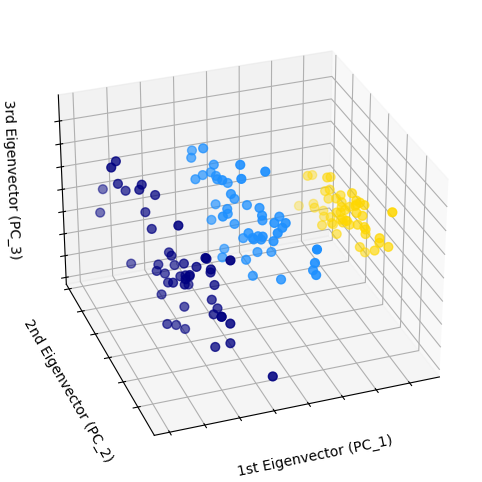

In [69]:
def plot_PCA_data(X_reduced, iris):

    colors = {'setosa':'gold', 'versicolor':'dodgerblue', 'virginica':'navy'}

    # initialize figure, axes
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d", elev=-150, azim=110)

    # plot the PCA-reduced data provided as a numpy array)
    ax.scatter(X_reduced[:, 0],
               X_reduced[:, 1],
               X_reduced[:, 2],
               c=iris.species.map(colors),
               s=40,
               )

    #ax.set_title("First three PCA dimensions")
    ax.set_xlabel('1st Eigenvector (PC_1)')
    ax.xaxis.set_ticklabels([])
    ax.set_ylabel('2nd Eigenvector (PC_2)')
    ax.yaxis.set_ticklabels([])
    ax.set_zlabel('3rd Eigenvector (PC_3)')
    ax.zaxis.set_ticklabels([])

    plt.show()

plot_PCA_data(X_reduced, iris)

PCA creates 3 new features that are a linear combination of the 4 original features.
In this new set of coordinates, it has become possible to differentiate between the three types of irises.

<Figure size 600x3600 with 0 Axes>

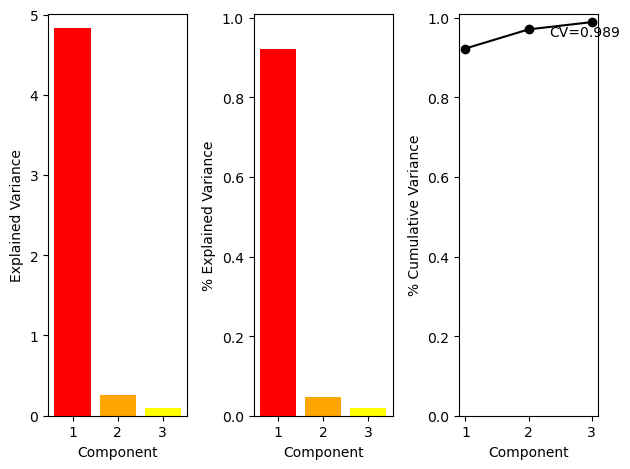

In [86]:
def plot_pca_variance(pca_object):

    colors = ['red', 'orange', 'yellow']

    # initialize figure, axes
    fig = plt.figure(figsize=(6, 36))
    fig, axs = plt.subplots(1, 3)
    n = pca_object.n_components_
    grid = np.arange(1, n + 1)

    # Explained variance
    ev = pca_object.explained_variance_
    axs[0].bar(grid, ev, color=colors)
    axs[0].set(xlabel="Component", ylabel="Explained Variance", ylim=(0.0, 5.01))
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[0].set_xticks(grid)
    axs[0].set_xticklabels(grid)

    # Explained variance ratio
    evr = pca_object.explained_variance_ratio_
    axs[1].bar(grid, evr, color=colors)
    axs[1].set(xlabel="Component", ylabel="% Explained Variance", ylim=(0.0, 1.01))
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[1].set_xticks(grid)
    axs[1].set_xticklabels(grid)

    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[2].plot(grid, cv, "o-", color='black')
    axs[2].set(xlabel="Component", ylabel="% Cumulative Variance", ylim=(0.0, 1.01))
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    axs[2].set_xticks(grid)
    axs[2].set_xticklabels(grid)
    # Cumulative variance value on the 3rd plot
    axs[2].annotate(f'CV={cv[-1]:.3f}', (grid[-1], cv[-1]), \
                    textcoords="offset points", xytext=(-5,-10), ha='center')

    fig.tight_layout()

plot_pca_variance(pca)

## 2. Create a pipeline

### 2.1 Generalities

A typical ML workflow is as follows:

1. split data into training/testing sets.
2. each of them goes through data cleaning/preprocessing.
3. they are then used as input for a ML model.

To avoid repetitive coding (first dealing with the training set, then with the testing set), it is possible to write a scikit-learn **pipeline**.\
A pipeline links every step of the data analysis, where  the output of a given step is used as the input for the next step.

Additional advantages:
- Less prone to (copy/paste) mistakes.
- Workflow easier to understand.
- Less prone to data leakage

### 2.2 Pipeline creation using Pipeline()

The syntax of a pipeline is as follows:\
Pipeline(steps = [(‘step name’, transform function), …])

In [10]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
# PCA already imported
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('lr_classifier', LogisticRegression(random_state=0))
                   ])

It is possible to display the pipeline.\
Clicking on the image provides the details of each step. 

In [11]:
from sklearn import set_config

set_config(display='diagram')
display(pipeline_lr)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('lr_classifier', LogisticRegression(random_state=0))])

### 2.2 Pipeline creation using make_pipeline()

There is an alternative way to define a pipeline, using the 'make_pipeline()' function.

In [36]:
from sklearn.pipeline import make_pipeline
alt_pipeline = make_pipeline(StandardScaler(), PCA(n_components=3), LogisticRegression(random_state=0))
display(alt_pipeline)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=3)),
                ('logisticregression', LogisticRegression(random_state=0))])

### 2.3 Running/evaluating the pipeline

#### 2.3.1 Split data in train/test sets

Take the (encoded) dataframe as X, after removing the 'species' columns (otherwise the model knows the answer).\
Take the 'species' column' as y. 

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_enc.drop(columns=['species']), iris_enc['species'], \
                                                    test_size=0.2, \
                                                    random_state=10)

#### 2.3.2 Train the model

In [14]:
# Pipeline.fit is the command to process data through the pipeline, including model fitting.
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('lr_classifier', LogisticRegression(random_state=0))])

#### 2.3.3 Predict the outcome on unseen data

In [15]:
# Pipeline.predict is the command to predict the outcome on unseen data thanks to the model trained just above.
y_pred = pipeline_lr.predict(X_test)

#### 2.3.4 Evaluate the model

In [16]:
# Pipeline.score computes the 'score' of the pipeline (preprocessing + model).
# It is possible (and desirable) to test various combinations of preprocessing methods + models to achieve the best possible score 
# Here the score is the accuracy of logistic regression.
score = pipeline_lr.score(X_test, y_test)
print('\nModel score:', score)


Model score: 1.0


### 2.4 Creating other pipelines

In [17]:
# StandardScaler already imported
# PCA already imported
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('dt_classifier', DecisionTreeClassifier(random_state=0))
                   ])
display(pipeline_dt)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('dt_classifier', DecisionTreeClassifier(random_state=0))])

In [18]:
# StandardScaler already imported
# PCA already imported
from sklearn.ensemble import RandomForestClassifier

pipeline_rf = Pipeline([
                    ('Scaler', StandardScaler()),
                    ('PCA', PCA(n_components=3)),
                    ('rf_classifier', RandomForestClassifier(random_state=0))
                   ])
display(pipeline_rf)

Pipeline(steps=[('Scaler', StandardScaler()), ('PCA', PCA(n_components=3)),
                ('rf_classifier', RandomForestClassifier(random_state=0))])

### 2.5 Running and evaluating all pipelines

In [19]:
# Create a dictionnary of pipelines
pipe_dict = {0:'Logistic Regression',1:'Decision Tree',2:'Random Forest'}
# Create a list of pipelines
pipelines = [pipeline_lr,pipeline_dt,pipeline_rf]

In [20]:
# run all pipelines within a for loop
for pipe in pipelines:
    pipe.fit(X_train,y_train)

In [21]:
# Evaluate all pipelines within a for loop
for i, model in enumerate(pipelines):
    print('{} Test accuracy: {}'.format(pipe_dict[i],np.round(model.score(X_test,y_test)*100),1))

Logistic Regression Test accuracy: 100.0
Decision Tree Test accuracy: 100.0
Random Forest Test accuracy: 100.0


In [22]:
test = -5+(5-(-5))*np.random.random_sample((10000,3))
test
final = np.where(
                ((test[:, 0]/10)**2 + (test[:, 1]/2)**2 + (test[:, 2]/4)**2) <=1
)

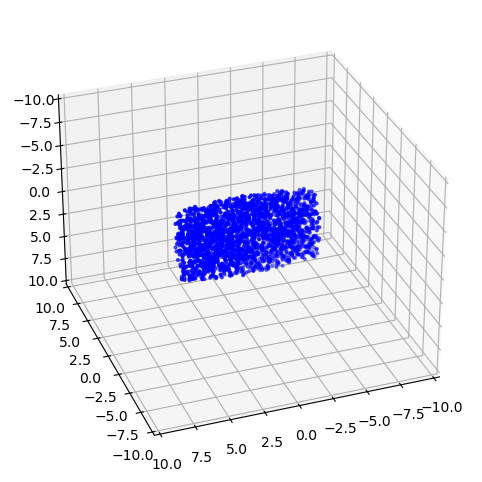

In [23]:
fig2 = plt.figure(1, figsize=(8, 6))
ax2 = fig2.add_subplot(111, projection="3d", elev=-150, azim=110)

#ax2.set_box_aspect([1.0, 1.0, 1.0])
#ax2.set_box_aspect((np.ptp(test[final][:, 0]), np.ptp(test[final][:, 1]), np.ptp(test[final][:, 2])))
#set_axes_equal(ax2)

ax2.set_xlim(-10,10)
ax2.set_ylim(-10,10)
ax2.set_zlim(-10,10)
ax2.set_xlabel='x'
ax2.set_ylabel='y'
ax2.set_zlabel='z'

ax2.scatter(test[final][:, 0], 
            test[final][:, 1],
            test[final][:, 2],
            c='blue',
            s=4,
            )

#ax2.scatter(test[:, 0], 
#            test[:, 1],
#            test[:, 2],
#            c='blue',
#            s=4,
#            )

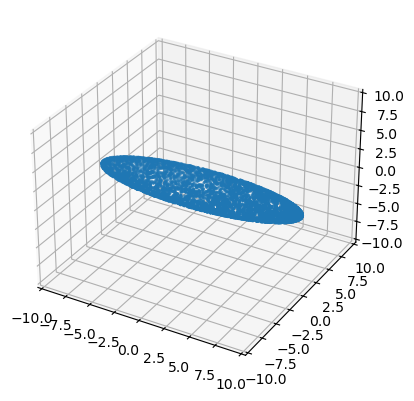

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, cos, pi


rng = np.random.default_rng(seed=0)

a, b, c = 10, 3, 1
N = 5000

phi = rng.uniform(0, 2*pi, size=N)
theta = np.arccos(1 - 2*rng.random(size=N))


x=a*sin(theta)*cos(phi)
y=b*sin(theta)*sin(phi)
z=c*cos(theta)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(x, y, z, s=2)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.set_zlim(-10,10)
plt.show()


(-10.0, 10.0)

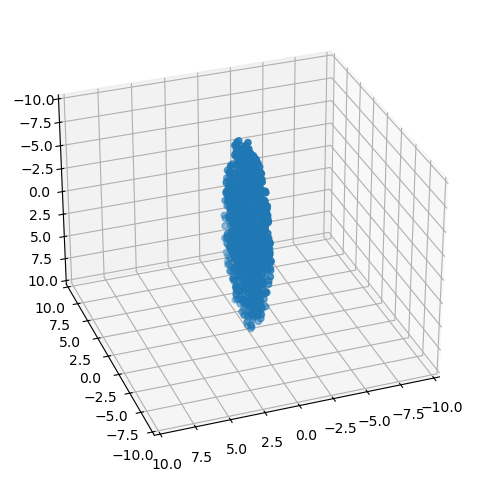

In [25]:
from numpy.random import uniform

n, a, b, c = 2000, 1.0, 4.0, 10.0

x, y, z = [uniform(-d, d, n) for d in (a, b, c)]
inside = ((x/a)**2+(y/b)**2+(z/c)**2) <=1 # Equation of an ellipsoid

fig3 = plt.figure(1, figsize=(8, 6))
ax3 = fig3.add_subplot(111, projection="3d", elev=-150, azim=110)
(xi, yi, zi) = (x[inside], y[inside], z[inside])

#ax3.scatter(x[inside], y[inside], z[inside])
ax3.scatter(xi, yi, zi)
ax3.set_xlim(-10,10)
ax3.set_ylim(-10,10)
ax3.set_zlim(-10,10)

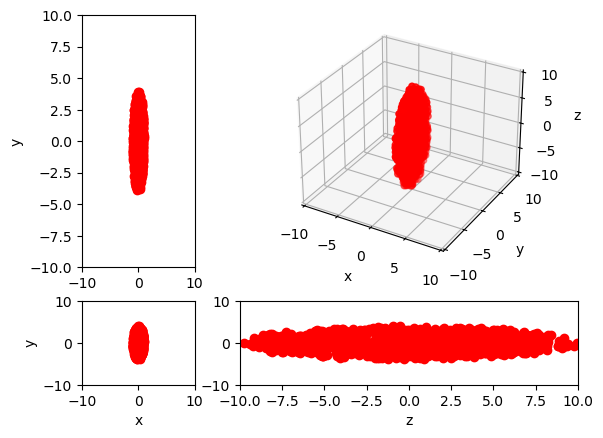

In [26]:
############### FIG. 2 ###############

# Create a Figure object
fig_ell = plt.figure() #figsize=(8.27,11.69)

# Prepares a grid of plots

import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

gs = gridspec.GridSpec(2, 2,
                       width_ratios=[1,3],
                       height_ratios=[3,1]
                       )

# 1st plot 
proj1 = plt.subplot(gs[0])
proj1.scatter(xi, yi, color='r')
proj1.set_xlim([-10,10])
proj1.set_ylim([-10,10])
proj1.set_ylabel('y')

# 2nd plot
proj2 = plt.subplot(gs[1], projection='3d')
proj2.scatter3D(xi, yi, zi, color='r')
proj2.set_xlabel('x')
proj2.set_xlim3d([-10,10])
proj2.set_ylabel('y')
proj2.set_ylim3d([-10,10])
proj2.set_zlabel('z')
proj2.set_zlim3d([-10,10])

# 3rd plot
proj3 = plt.subplot(gs[2])
proj3.scatter(xi, yi, color='r')
proj3.set_xlim([-10,10])
proj3.set_xlabel('x')
proj3.set_ylim([-10,10])
proj3.set_ylabel('y')

# 4th plot
proj4 = plt.subplot(gs[3])
proj4.scatter(zi, yi, color='r')
proj4.set_xlim([-10,10])
proj4.set_xlabel('z')
proj4.set_ylim([-10,10])

# removes ticklabels
def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        for tl in ax.get_xticklabels() + ax.get_yticklabels():
            tl.set_visible(False)

# Display plot on screen
plt.show()

# Save figure
fig_ell.subplots_adjust(hspace=0, wspace=0)
#fig2.savefig("test.pdf", orientation='portrait', bbox_inches='tight')

In [27]:
CovMat= ((88.5333, -33.6, -5.33333), 
         (-33.6, 15.4424, 2.66667), 
         (-5.33333, 2.66667, 0.484848))

eigenvalues= (0.0098, 0.4046, 104.7)

eigenvectors= ((0.93, 0.36, -0.03), (-0.36, 0.9, -0.23), (-0.06, 0.23, 0.97))

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# I'm taking an arbitrary symmetric matrix
COV = np.array([[1, -0.7, 0.33],
                [-0.7, 4, 0.56],
                [0.33, 0.56, 6]])

eigenvalues, eigenvectors = np.linalg.eig(COV)
#theta = np.linspace(0, 2*np.pi, 1000);
#ellipsis = (1/np.sqrt(eigenvalues[None,:]) * eigenvectors) @ [np.sin(theta), np.cos(theta)]
#plt.plot(ellipsis[0,:], ellipsis[1,:])

In [29]:
eigenvectors

array([[-0.96991015, -0.24171868,  0.02909248],
       [-0.22770051,  0.94291281,  0.24303891],
       [ 0.08617871, -0.22910154,  0.96958017]])

In [30]:
phi = rng.uniform(0, 2*pi, size=N)
theta = np.arccos(1 - 2*rng.random(size=N))


x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

R = 

rotation_matrix = np.array([[np.cos(rotation_angle), -np.sin(rotation_angle)],
                            [np.sin(rotation_angle), np.cos(rotation_angle)]])

x=a*sin(theta)*cos(phi)
y=b*sin(theta)*sin(phi)
z=c*cos(theta)

SyntaxError: invalid syntax (3832981454.py, line 9)